In [1]:
import os
from pathlib import Path

import scipy
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider

import numpy as np 

In [2]:
def load_attention_matrices(data_path, attention_type, num_layers):
    causal_attention_matrices = []

    for layer in range(num_layers):
        A = np.load(os.path.join(data_path, f"{attention_type}", f"A_layer{layer}.npy")).squeeze()
        causal_attention_matrices.append(A)

    return np.asarray(causal_attention_matrices)


---

In [5]:
model_name_or_path, num_layers = "EleutherAI/gpt-neo-1.3B", 24
# model_name_or_path, num_layers = "princeton-nlp/Sheared-LLaMA-1.3B", 24
# model_name_or_path, num_layers = "meta-llama/Llama-2-7b-hf", 32
# model_name_or_path, num_layers = "meta-llama/Llama-2-7b-chat-hf", 32
# model_name_or_path, num_layers = "mistralai/Mistral-7B-v0.1", 32
# model_name_or_path, num_layers = "mistralai/Mistral-7B-Instruct-v0.2", 32

In [6]:
data_path = f"/data/attention_data/{model_name_or_path.split('/')[-1]}"

In [7]:
causal_attention_matrices = load_attention_matrices(data_path, "causal", num_layers)
causal_attention_matrices.shape

(24, 16, 160, 160)

In [8]:
bi_attention_matrices = load_attention_matrices(data_path, "bidirectional", num_layers)
bi_attention_matrices.shape

(24, 16, 160, 160)

/tmp/ipykernel_38252/101665236.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots()


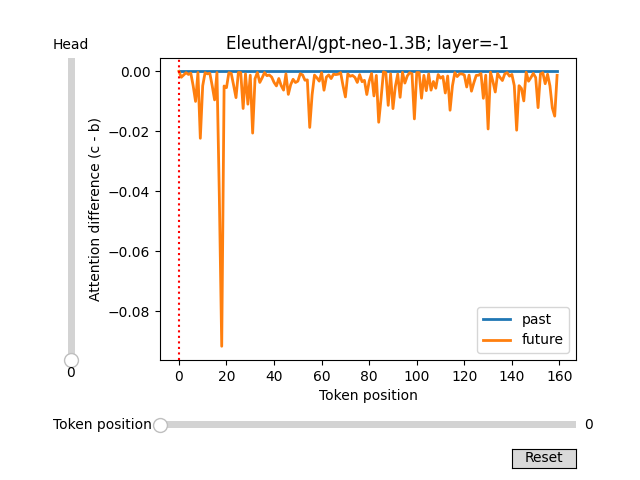

In [29]:
%matplotlib widget

num_tokens = causal_attention_matrices.shape[-1]
num_heads = causal_attention_matrices.shape[1]

layer = -1

# The parametrized function to be plotted
def f(head, position):
    H_c = causal_attention_matrices[layer][head]
    H_b = bi_attention_matrices[layer][head]
    difference = H_c - H_b
    difference_past = np.tril(difference, k=-1)
    difference_future = np.triu(difference, k=1)

    return difference_past[position], difference_future[position]

# Define initial parameters
init_head = 0
init_position = 0

# Create the figure and the line that we will manipulate
fig, axes = plt.subplots()
line_past, = axes.plot(f(init_head, init_position)[0], lw=2, label="past")
line_future, = axes.plot(f(init_head, init_position)[1], lw=2, label="future")
line_token = axes.axvline(init_position, color="red", linestyle="dotted")
axes.set_xlabel("Token position")
axes.set_ylabel("Attention difference (c - b)")
axes.legend(loc="best")
axes.set_title(f"{model_name_or_path}; layer={layer}")

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
ax_pos = fig.add_axes([0.25, 0.1, 0.65, 0.03])
pos_slider = Slider(
    ax=ax_pos,
    label="Token position",
    valmin=0,
    valmax=num_tokens - 1,
    valstep=1,
    valinit=init_position,
    initcolor='none',
)

# Make a vertically oriented slider to control the amplitude
ax_head = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
head_slider = Slider(
    ax=ax_head,
    label="Head",
    valmin=0,
    valmax=num_heads - 1,
    valstep=1,
    valinit=init_head,
    initcolor='none',
    orientation="vertical"
)

# The function to be called anytime a slider's value changes
def update(val):
    line_past.set_ydata(f(head_slider.val, pos_slider.val)[0])
    line_future.set_ydata(f(head_slider.val, pos_slider.val)[1])
    line_token.set_xdata([pos_slider.val])
    # recompute the ax.dataLim
    axes.relim()
    # update ax.viewLim using the new dataLim
    axes.autoscale_view()
    fig.canvas.draw_idle()


# register the update function with each slider
pos_slider.on_changed(update)
head_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    pos_slider.reset()
    head_slider.reset()
button.on_clicked(reset)

plt.show();